
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Intraseasonal Weather Types (IWT, at daily scale) following the methodology explained in Anderson et al. (2019)

inputs required: 
  * Daily values of Madden-Julian Oscillation (MJO) parameters (rmm1, rmm2, phase, mjo)
  
in this notebook:
  * Obtain MJO categories (25) based on rmm1, rmm2, and phase 
  * Fit the autoregressive logistic model with a markov order 3 and seasonality
  * Time-series simulation of *n* simulations of 1000 years of the 25 categories
  * Randomly obtain pairs of rmm1, rmm2 and phase from the simulated time-series


### Workflow:

<div>
<img src="resources/nb01_04.png" width="300px">
</div>

Intra-seasonal Weather Types (**IWTs**) are representative of the **Madden-Julian Oscillation (MJO)**, which is a broad region of anomalous atmospheric circulation and convective precipitation anomalies that propagates eastward around the equator on one to two-month timescales (Madden & Julian, 1972) and exhibits correlations with relevant coastal climatology such as tropical cyclone genesis (Slade & Malony, 2013) and surface wind wave anomalies (Marshal et al., 2015, Godoi et al., 2019) 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import date, timedelta, datetime

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.mjo import MJO_Categories
from teslakit.alr import ALR_WRP
from teslakit.util.operations import GetRepeatedValues

from teslakit.plotting.mjo import Plot_MJO_phases, Plot_MJO_Categories



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

MJO_hist = db.Load_MJO_hist()  # historical MJO

# MJO ALR parameters
alr_markov_order = 3
alr_seasonality = [2, 4, 8]

# Simulation
num_sims = 100
d1_sim = np.datetime64('2000-01-01').astype(datetime)
d2_sim = np.datetime64('3000-01-01').astype(datetime)



## MJO phases and categories

It is common practice in the MJO literature to separate the longitudinal location of the center of convection into eight longitudinal phases (Wheeler & Hendon, 2004). This convention was preserved in a daily index in this study, intended to be a proxy for intra-seasonal MJO oscillations by clustering the two leading PCs (henceforth referred to as IPC1 and IPC2) of outgoing longwave radiation into eight pre-defined longitudinal phases and further separating into three categories of low, medium, and high convection strength (analogous to conventions in Lafleur et al., (2015)) (Figure 4). A separate cluster was created for times when the location of the MJO is considered to have low certainty (when the vector magnitude of PC1 and PC2 is less than 1 (Wheeler & Hendon, 2004)). Altogether, the 25 clusters of Intra-seasonal Weather Types (IWTs) effectively create categorical MJO.

In [4]:
# --------------------------------------
# Calculate MJO categories (25 used) 

rmm1 = MJO_hist['rmm1']
rmm2 = MJO_hist['rmm2']
phase = MJO_hist['phase']

categ, d_rmm_categ = MJO_Categories(rmm1, rmm2, phase)
MJO_hist['categ'] = (('time',), categ)

print(MJO_hist)


<xarray.Dataset>
Dimensions:  (time: 15191)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-08-03
Data variables:
    mjo      (time) float64 ...
    phase    (time) int64 6 7 7 7 7 7 7 6 6 6 7 7 7 ... 2 2 2 2 2 3 3 3 3 3 4 4
    rmm1     (time) float64 0.1425 -0.2042 -0.1586 ... 0.6166 0.5537 0.9844
    rmm2     (time) float64 1.05 1.374 1.539 1.46 ... -0.7819 -0.552 -0.4286
    categ    (time) int64 22 23 15 23 23 23 23 22 14 ... 10 19 19 19 19 25 25 20


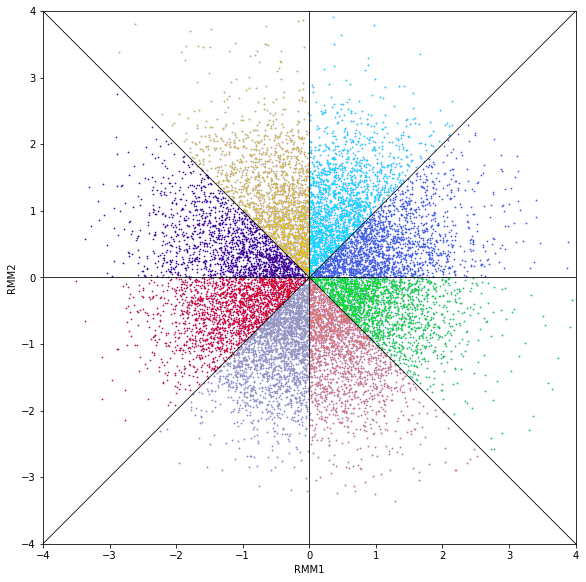

In [5]:
# plot MJO phases
Plot_MJO_phases(rmm1, rmm2, phase);


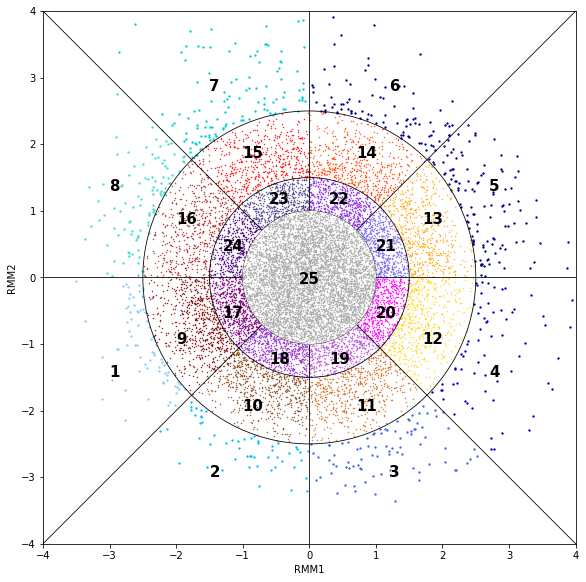

In [6]:
# plot MJO categories
Plot_MJO_Categories(rmm1, rmm2, categ);



## Autoregressive Logistic Regression

Synthetic time series of the MJO are obtained with a Markov chain of the predefined IWT categorical states (statistically significant to the third order) and subsequent sampling from joint distributions of IPC1 and IPC2 within each cluster. When consecutive days in the synthetic record are sampled from the same categorical state, the randomly picked EOF pairs are ordered to preserve counterclockwise propagation of the MJO around the globe in a consistent direction. 

In [7]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# MJO historical data for fitting
bmus_fit = xr.Dataset(
    {
        'bmus'  :(('time',), MJO_hist.categ.values[:]),
    },
    {'time' : MJO_hist.time.values[:]}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'seasonality': (True, alr_seasonality),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.MJO.alrw)
ALRW.SetFitData(25, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)



Fitting autoregressive logistic model ...
Optimization done in 39.59 seconds



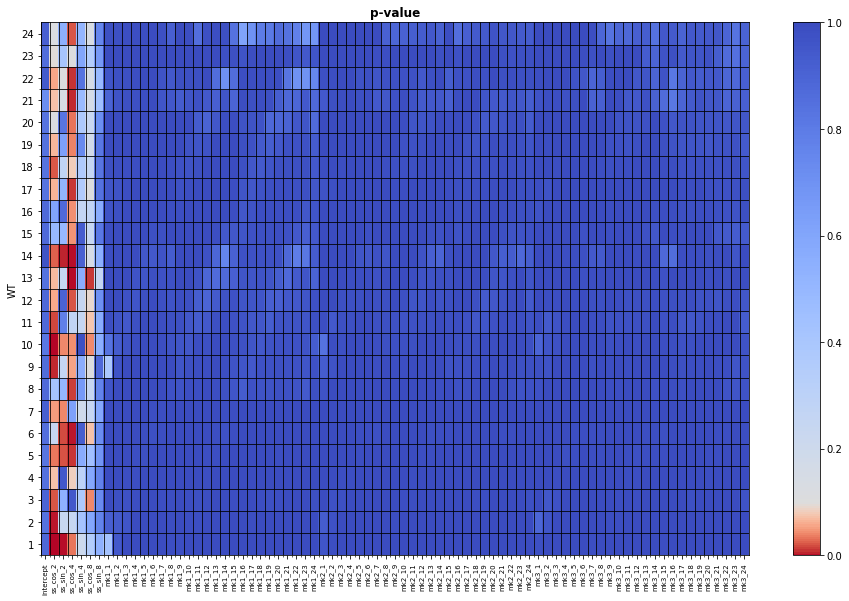

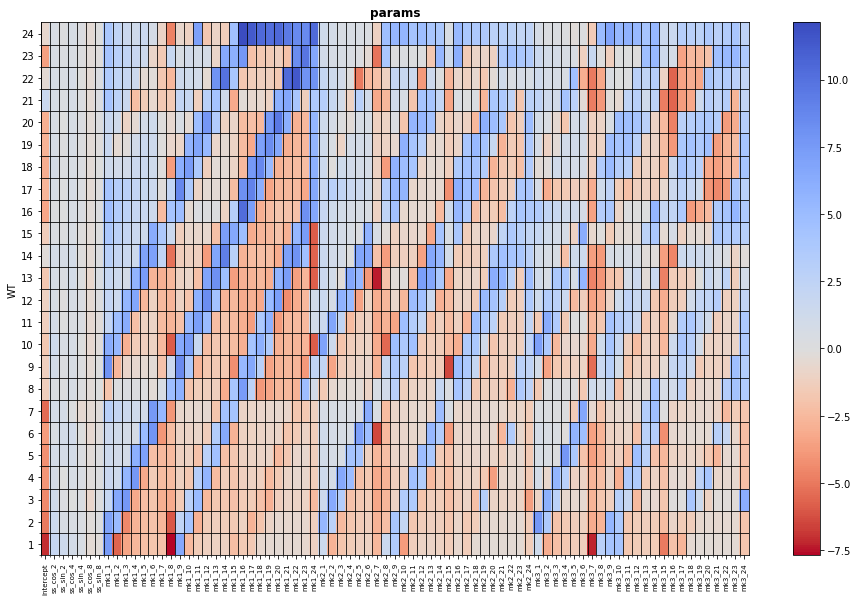

In [8]:
# show fit report
ALRW.Report_Fit()


In [9]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates
dates_sim = [d1_sim + timedelta(days=i) for i in range((d2_sim-d1_sim).days+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)


ALR model fit   : 1979-01-01 --- 2020-08-03
ALR model sim   : 2000-01-01 --- 3000-01-01

Launching 100 simulations...

Sim. Num. 100: 100%|██████████| 365241/365241 [05:48<00:00, 1047.52it/s]



In [10]:
# --------------------------------------
# MJO rmm1, rmm2, phase generation

# solve each ALR simulation
l_MJO_sim = []
for s in ALR_sim.n_sim:
    
    evbmus_sim = ALR_sim.sel(n_sim=s).evbmus_sims.values[:]

    # Generate rmm1 and rmm2 simulated values
    rmm12_sim = np.empty((len(evbmus_sim), 2)) * np.nan
    mjo_sim = np.empty(len(evbmus_sim)) * np.nan
    phase_sim = np.empty(len(evbmus_sim)) * np.nan

    categs = np.unique(evbmus_sim)
    for c in categs:
        c_ix = np.where(evbmus_sim==c)[0]
    
        # select random values for rmm1, rmm2
        options = d_rmm_categ['cat_{0}'.format(int(c))]
        r = np.random.randint(options.shape[0], size=len(c_ix))
        rmm12_sim[c_ix,:] = options[r,:]


    # calculate mjo and phase
    mjo_sim = np.sqrt(rmm12_sim[:,0]**2 + rmm12_sim[:,1]**2)
    phase_sim = np.arctan2(rmm12_sim[:,0], rmm12_sim[:,1])

    # internally reorder days with same category (counter-clockwise phase ascend)
    l_ad = GetRepeatedValues(evbmus_sim)
    for s,e in l_ad:

        # get sort index by MJO phase value
        ixs = np.argsort(phase_sim[s:e])  

        # sort mjo
        rmm12_sim[s:e,0] = rmm12_sim[s:e,0][ixs]
        rmm12_sim[s:e,1] = rmm12_sim[s:e,1][ixs]
        mjo_sim[s:e] = mjo_sim[s:e][ixs]
        phase_sim[s:e] = phase_sim[s:e][ixs]

    
    # append simulated PCs
    l_MJO_sim.append(
        xr.Dataset(
            {
                'mjo'         :(('time',), mjo_sim),
                'phase'       :(('time',), phase_sim),
                'rmm1'        :(('time',), rmm12_sim[:,0]),
                'rmm2'        :(('time',), rmm12_sim[:,1]),
                'evbmus_sims' :(('time',), evbmus_sim),

            },
            {'time' : dates_sim}
        )
    )
    
# concatenate simulations
MJO_sim = xr.concat(l_MJO_sim, 'n_sim') 

# store simulated MJO
db.Save_MJO_sim(MJO_sim)




##  Validation

Synthetic and historical MJO categories comparison:
- Perpetual Year
- Cluster Transition Probabilities

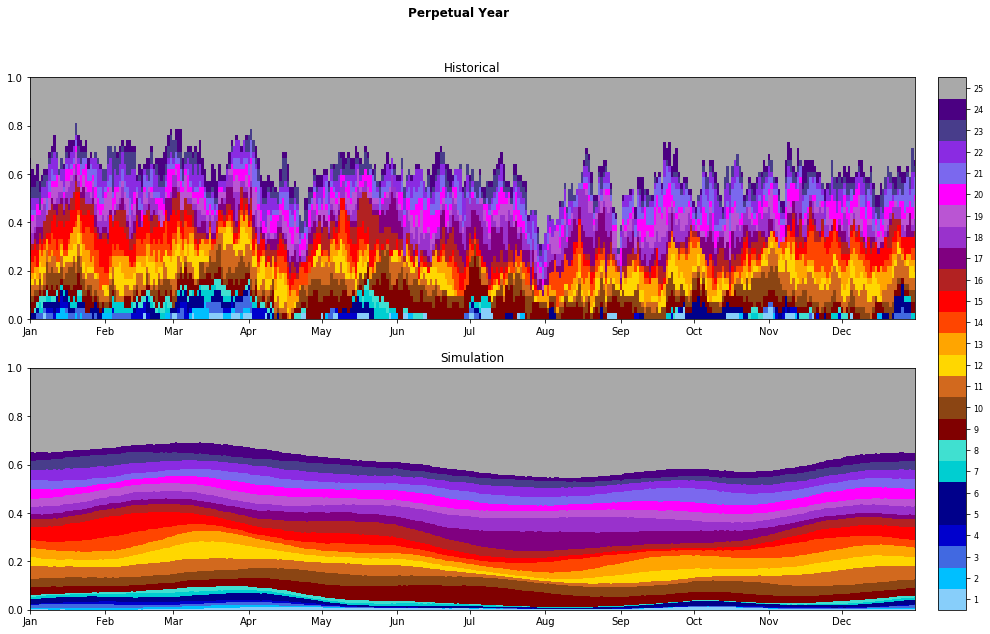

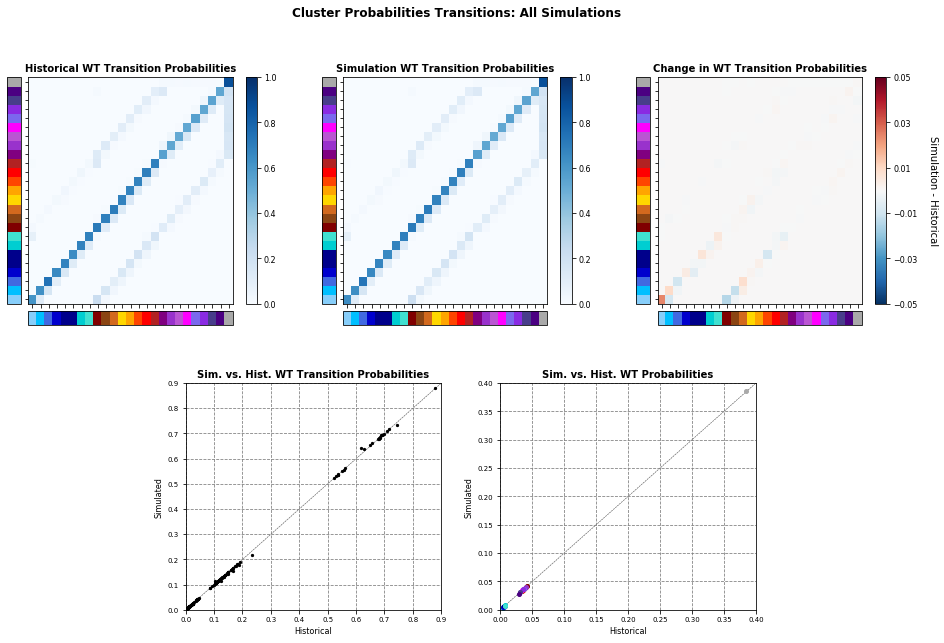

In [11]:
# show simulation report
ALRW.Report_Sim();
